In [1]:
import sqlite3 as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [2]:
# My Docker imploded so I'm using google colab notebooks. The 
# sqlite file is in my google drive, so it needs to be mounted
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# PART 1

# Problem 1

sqlite_file = '/content/drive/MyDrive/CMSC320/lahman2014.sqlite'
conn = sq.connect(sqlite_file)


In [4]:
# For readability, the query string is separated into 2. This first one is
# to get the payroll data from the salaries table

salaries = """
SELECT yearID, teamID, sum(salary) as total_payroll 
FROM Salaries GROUP BY yearID, teamID
"""

# The previous salaries query string is joined into this string so that only 
# 1 query is performed, leaving 1 complete dataframe

query = """ 
SELECT T.yearID as year, T.teamID as team, S.total_payroll, 
CAST(W AS FLOAT)/CAST(G AS FLOAT)*100.00 as win_rate 
FROM Teams T
INNER JOIN (""" + salaries + """) S 
ON T.yearID=S.yearID AND T.teamID=S.teamID
"""
# Payroll data from before 1985 does not exist, and there are a few 2014
# rows from the Teams table with no corresponding row in the Salaries table. 
# To deal with this, I used SQL's inner join, which ensured that only rows were
# only included if the team and year were present in both tables. 

df = pd.read_sql(query, conn)
df


,year,team,total_payroll,win_rate
0,1985,ATL,14807000.0,40.740741
1,1985,BAL,11560712.0,51.552795
2,1985,BOS,10897560.0,49.693252
3,1985,CAL,14427894.0,55.555556
4,1985,CHA,9846178.0,52.147239
...,...,...,...,...
853,2014,SLN,120693000.0,55.555556
854,2014,TBA,72689100.0,47.530864
855,2014,TEX,112255059.0,41.358025
856,2014,TOR,109920100.0,51.234568


In [5]:
# PART 2

# Problem 2 

# This code will create a scatter plot where each point
# is (x = year, y = team's payroll that year) for every team

# Get index of first row where the year is 1990
i = (df.index[df['year'] == 1990])[0]

# Drop all years before 1990, as we are not interested in them.
# By doing this, the 5 intervals we create later will be 5 years each.
# With less years per interval, the averages calulated over those intervals
# will be more meaningful as we observe how they change with time
df.drop(df.index[:i], inplace=True)
df

,year,team,total_payroll,win_rate
130,1990,ATL,14555501.0,40.123457
131,1990,BAL,9680084.0,47.204969
132,1990,BOS,20558333.0,54.320988
133,1990,CAL,21720000.0,49.382716
134,1990,CHA,9491500.0,58.024691
...,...,...,...,...
853,2014,SLN,120693000.0,55.555556
854,2014,TBA,72689100.0,47.530864
855,2014,TEX,112255059.0,41.358025
856,2014,TOR,109920100.0,51.234568


<Figure size 360x225 with 0 Axes>

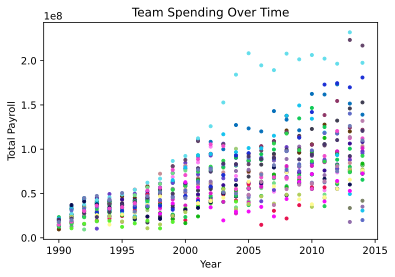

In [6]:
# This function assigns each teamID a random color. Random color uses the teamID
# as a seed, so the same color will be used each time that team appears 
# on the plot

def color_team(team):
  rgb = []
  r = random.Random(team)
  rgb.append(r.random())
  rgb.append(r.random())
  rgb.append(r.random())
  return rgb

# Get list of rgb triples, one for each team
cols = []
for team in df['team']:
  col = color_team(team)
  cols.append(col)

# Create plot 
plt.figure(figsize=(3,1.875), dpi=120)
fig, ax = plt.subplots()
ax.set_xlabel("Year")
ax.set_ylabel("Total Payroll")
ax.set_title("Team Spending Over Time")
ax.scatter(df['year'], df['total_payroll'], c=cols, marker=".")
plt.show()

Question 1: 
This scatterplot represents every total_payroll with a point. Points of the same color represent the same team. 

Back in 1990-1995, it appears all teams spent around the same, low amount on payroll. The points are all very concentrated throughout the early 90s. Into the 2000s, the variance inceased dramatically, with the overall average increasing steadily as well. By 2014, the range of payroll spending had increased by tens of millions, with each team paying radically different amounts compared to each other. 

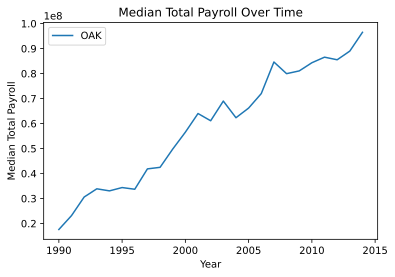

In [7]:
# Problem 3 

# We will examine how the median total_payroll changes with time

# Create and label axes
fig, ax = plt.subplots()
ax.set_xlabel("Year")
ax.set_ylabel("Median Total Payroll")
ax.set_title("Median Total Payroll Over Time")

# Caluclate median payroll for each year in desired range
years = range(1990, 2015)
medians = []
for y in years:
  section = df[df['year'] == y]
  medians.append(section['total_payroll'].median())

# Create line plot
ax.plot(years, medians)
plt.legend(['OAK', 'BOS', 'NYA', 'ATL', 'TBA'])
plt.show()


In [8]:
# Problem 4

# Create bins for 5 intervals: 
# [1990, 1995) , [1995, 2000) , [2000, 2005) , [2005, 2010) , [2010, 2015)
intervals = ['1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014']
df['interval'] = pd.cut(x=df['year'], bins=[1990, 1995, 2000, 2005, 2010, 2015],
                        labels=intervals,
                        right=False)

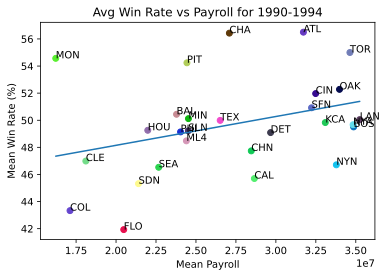

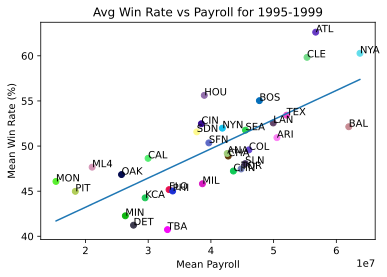

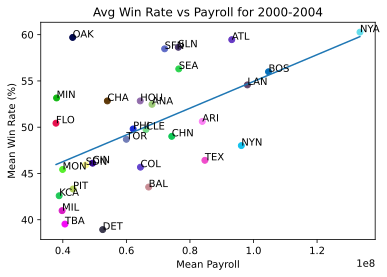

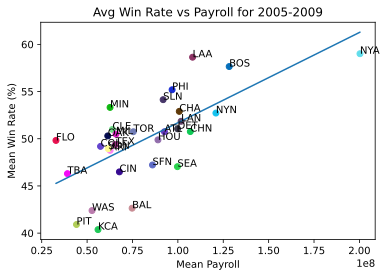

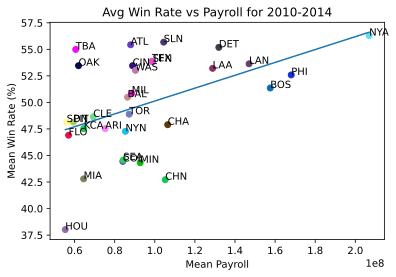

In [9]:
# Function to create scatterplot with each point labeled by team
def plot_interval(interval, teams, mean_winrates, mean_payrolls):

  # Get list of rgb triples, one for each team
  cols = []
  for team in teams:
    rgb = color_team(team)
    cols.append(rgb)

  # Create and label axes
  fig, ax = plt.subplots()
  ax.set_xlabel("Mean Payroll")
  ax.set_ylabel("Mean Win Rate (%)")
  ax.set_title("Avg Win Rate vs Payroll for " + interval)

  # Make these columns into numpy arrays, so that polyfit works
  mean_payrolls = np.array(mean_payrolls)
  mean_winrates = np.array(mean_winrates)

  # Create scatter plot
  ax.scatter(mean_payrolls, mean_winrates, c=cols)

  # Get slope (m) and intercept (b) so that a regression line can be plotted
  m, b = np.polyfit(mean_payrolls, mean_winrates, 1)

  # Create regression line (y = m*x + b)
  plt.plot(mean_payrolls, m*mean_payrolls + b)

  # Label each point with corresponding team
  for i, txt in enumerate(teams):
    ax.annotate(txt, (mean_payrolls[i], mean_winrates[i]))
  
  plt.show()

# For every interval, we calculate each team's average winrate and payroll
for i in intervals:
  # Get section of dataframe that matches the current interval
  section = df[df['interval'] == i]

  # This dictionary will map each team to its active years, total payroll, 
  # and total win rate for the 5-year period. This will be used for caluclating
  # the means.
  team_stats = {}
  for index, row in section.iterrows():
    team = row['team']
    pay = row['total_payroll']
    wr = row['win_rate']
    if team in team_stats.keys():
      t = team_stats[team]
      # update values
      t[0] += 1
      t[1] += pay
      t[2] += wr
    else:
      team_stats.update({team : [1, pay, wr]})
  
  # Compute mean payroll and mean winrate
  teams = list(team_stats.keys())
  mean_payrolls = []
  mean_winrates = []
  for t in teams:
    mean_payrolls.append(team_stats[t][1]/team_stats[t][0])
    mean_winrates.append(round(team_stats[t][2]/team_stats[t][0], 2))
  # Calls plot function when all data for this interval has been computed
  plot_interval(i, teams, mean_winrates, mean_payrolls)

 Question 2: These 5 scatterplots show each team's average win rate as it relates to their average payroll spending during each 5-year period.

The plots show that, prior to 2000, teams that had high win rates (>50%) tended to be the teams that spent the most money. After 2000, the teams with high win rates shifted towards the left, indicating less money spent per win.  

Chicago seemed to do pretty well over the years, having mostly above 50% wins with relatively low spending accross the 5 periods. New York did not have the most efficient solution to buying wins, but it had the most consistent, showing high win rates every period at the cost of massive spending. Oakland was pretty average before 2000, but became the most efficient in 2000-2004 and did pretty well in 2014, as shown by how close they are to the top-left in these periods.



In [10]:
# PART 3

# Problem 5

# Get standard deviations for payrolls
stds = df.groupby('year').std()
means = df.groupby('year').mean()

# Create a list of the standardized payrolls to be inserted into the dataframe
# as a column
standardized_payrolls = []
for row in df.itertuples():
    # Standardized payroll = payroll - avg_payroll / std
    sp = (row.total_payroll - means.loc[row.year]['total_payroll'])
    /(stds.loc[row.year]['total_payroll'])
    standardized_payrolls.append(sp)
df.insert(3, 'standardized_payroll', standardized_payrolls)
df

,year,team,total_payroll,standardized_payroll,win_rate,interval
130,1990,ATL,14555501.0,-2.516853e+06,40.123457,1990-1994
131,1990,BAL,9680084.0,-7.392270e+06,47.204969,1990-1994
132,1990,BOS,20558333.0,3.485979e+06,54.320988,1990-1994
133,1990,CAL,21720000.0,4.647646e+06,49.382716,1990-1994
134,1990,CHA,9491500.0,-7.580854e+06,58.024691,1990-1994
...,...,...,...,...,...,...
853,2014,SLN,120693000.0,2.089298e+07,55.555556,2010-2014
854,2014,TBA,72689100.0,-2.711092e+07,47.530864,2010-2014
855,2014,TEX,112255059.0,1.245504e+07,41.358025,2010-2014
856,2014,TOR,109920100.0,1.012008e+07,51.234568,2010-2014


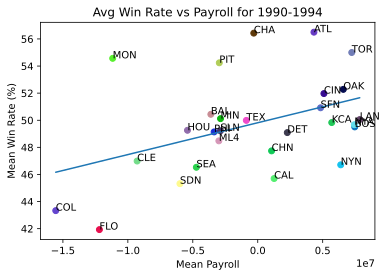

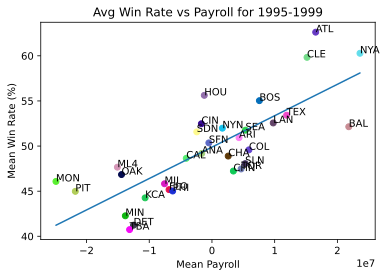

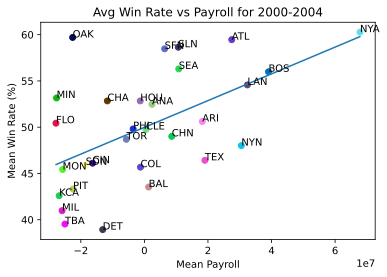

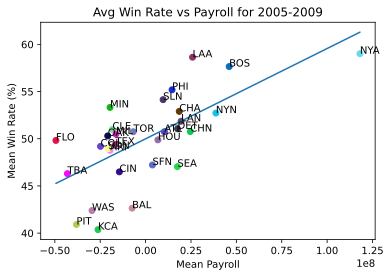

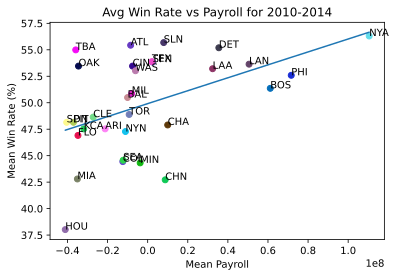

In [11]:
# Problem 6

# *****The below code is copied from part 4, but uses the 'standardized_payroll'
# column instead of the mean payroll

# For every interval, we calculate each team's average winrate and payroll
for i in intervals:
  section = df[df['interval'] == i]
  team_stats = {}
  for index, row in section.iterrows():
    team = row['team']
    pay = row['standardized_payroll']
    wr = row['win_rate']
    if team in team_stats.keys():
      t = team_stats[team]
      t[0] += 1
      t[1] += pay
      t[2] += wr
    else:
      team_stats.update({team : [1, pay, wr]})
  teams = list(team_stats.keys())
  mean_payrolls = []
  mean_winrates = []
  for t in teams:
    mean_payrolls.append(team_stats[t][1]/team_stats[t][0])
    mean_winrates.append(round(team_stats[t][2]/team_stats[t][0], 2))
  plot_interval(i, teams, mean_winrates, mean_payrolls)

Question 3: The formula used in calculating the standardized payroll takes each payroll and subtracts the average, then divides by the standard deviation. The subtraction gives the point a distance from the mean, (negative means less than the mean), then dividing by the standard deviation makes that distance standard, so that it is comparable to other time periods where the mean and range differ by a lot. There is not much visually different about the graphs, but the x-axis now has unitless values that indicate how far from average the payroll spending is in the context of the the whole 25 years.  



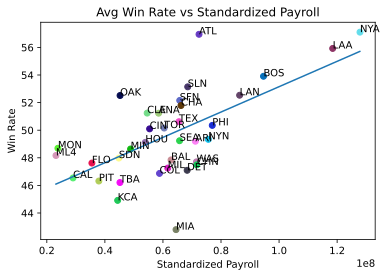

In [12]:
# Problem 7

# Get average stats for each team
team_avgs = df.groupby('team').mean()

# Get all unique team names
teams = set(df['team'])

# These lists will be passed in as data for the plots
mean_sp = []
mean_win = []
cols = []

# Every team gets its color, mean standardized payroll, 
# and mean win rate
for team in teams:
  rgb = color_team(team)
  cols.append(rgb)
  mean_sp.append(team_avgs.loc[team]['total_payroll'])
  mean_win.append(team_avgs.loc[team]['win_rate'])

# Create and label axes
fig, ax = plt.subplots()
ax.set_xlabel("Standardized Payroll")
ax.set_ylabel("Win Rate")
ax.set_title("Avg Win Rate vs Standardized Payroll")

mean_sp = np.array(mean_sp)
mean_win = np.array(mean_win)

# Plot the scatter plot and regression lone
ax.scatter(mean_sp, mean_win, c=cols)
m, b = np.polyfit(mean_sp, mean_win, 1)
plt.plot(mean_sp, m*mean_sp + b)

# Label each point with corresponding team
for i, txt in enumerate(teams):
  ax.annotate(txt, (mean_sp[i], mean_win[i]))
plt.show()



In [13]:
# Problem 8

# Add efficiency column using the formulas
df["efficiency"] = df.win_rate - (50 + (2.5*(df.standardized_payroll)))
df

,year,team,total_payroll,standardized_payroll,win_rate,interval,efficiency
130,1990,ATL,14555501.0,-2.516853e+06,40.123457,1990-1994,6.292122e+06
131,1990,BAL,9680084.0,-7.392270e+06,47.204969,1990-1994,1.848067e+07
132,1990,BOS,20558333.0,3.485979e+06,54.320988,1990-1994,-8.714944e+06
133,1990,CAL,21720000.0,4.647646e+06,49.382716,1990-1994,-1.161912e+07
134,1990,CHA,9491500.0,-7.580854e+06,58.024691,1990-1994,1.895214e+07
...,...,...,...,...,...,...,...
853,2014,SLN,120693000.0,2.089298e+07,55.555556,2010-2014,-5.223246e+07
854,2014,TBA,72689100.0,-2.711092e+07,47.530864,2010-2014,6.777729e+07
855,2014,TEX,112255059.0,1.245504e+07,41.358025,2010-2014,-3.113762e+07
856,2014,TOR,109920100.0,1.012008e+07,51.234568,2010-2014,-2.530021e+07


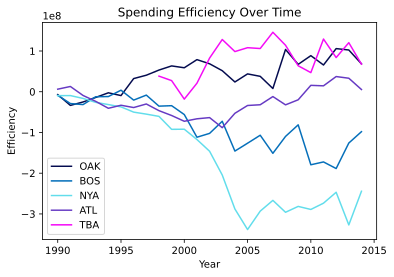

In [14]:
# Create line plot
fig, ax = plt.subplots()
ax.set_xlabel("Year")
ax.set_ylabel("Efficiency")
ax.set_title("Spending Efficiency Over Time")

for t in ['OAK', 'BOS', 'NYA', 'ATL', 'TBA']:
  section = df[df['team'] == t]
  ax.plot(list(section['year']), list(section['efficiency']), 
          color=color_team(t), label=t)

plt.legend(['OAK', 'BOS', 'NYA', 'ATL', 'TBA'])
plt.show()

Question 4: This line plot shows the efficiency for Oakland, Boston, New York, Atlanta, and Tampa Bay from 1990 to 2014. A positive efficiency indicates that the team is winning more games then expected given how much they spend. A negative efficicency indicates that the team is winning less games than expected. 

This plot lets us observe how teams improve and disimprove their spending efficiency relative to each other, which is not clearly apparent from the previous scatterplots. In 1990, the efficiencies were all around average, as they were still going by traditional pricings of players. As 2000 hit, we see Tampa Bay hit a massive spike in efficiency while Oakland and Atlanta steadily improved during into the 2010's. High-spenders like New York and Boston, who didn't catch on to the new strategy, had a greate decline in efficiency during the moneyball era, but made small recoveries afterwards in the mid 2010's.

In [15]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('project2_EvanDeist.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/project2_EvanDeist.ipynb to pdf
[NbConvertApp] Support files will be in project2_EvanDeist_files/
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbConvertApp] Making directory ./project2_EvanDeist_files
[NbC

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'